In [1]:
# import dependencies
%load_ext lab_black
%matplotlib inline
from matplotlib import style

style.use("fivethirtyeight")
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# The latest date in the dataset
latest_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).all()
latest_date[0][0]


# latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# latest_date[0]

'2017-08-23'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
year_ago_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"The date 1 year ago: {year_ago_date}")

The date 1 year ago: 2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
year_prcp = (
    session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp)
    .filter(func.strftime("%Y-%m-%d", Measurement.date) >= year_ago_date)
    .all()
)

# year_prcp = (
#     session.query(Measurement.date, Measurement.prcp)
#     .filter(Measurement.date >= year_ago_date)
#     .all()
# )

# year_prcp = (
#     session.query(Measurement.date, Measurement.prcp)
#     .filter(Measurement.date >= year_ago_date)
#     .group_by(Measurement.date)
#     .all()
# )


# Save the query results as a Pandas DataFrame and set the index to the date column
year_prcp_df = pd.DataFrame(year_prcp, columns=["date", "precipitation"])
year_prcp_df.set_index("date", inplace=True)

# Sort the dataframe by date
year_prcp_df.sort_values("date", ascending=True)

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


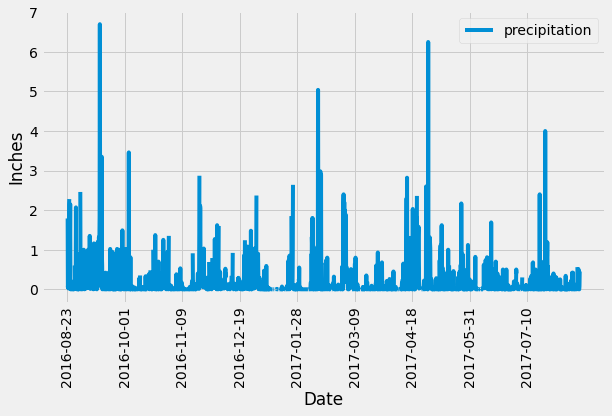

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
df_matplot = year_prcp_df.sort_values("date", ascending=True).reset_index()

df_matplot.plot(
    x="date",
    xticks=(0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000),
    y="precipitation",
    #     title="Precipitation: 2016/08/23-2017/08/23",
    label="precipitation",
    rot=90,
    figsize=(9, 5),
)

plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend()
# plt.tight_layout()
plt.savefig("Images/sabrina_precipitation.png")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).distinct().count()
station_count

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_active = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature of the most active station?
station_active_most = "USC00519281"

temps = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == station_active_most)
    .all()
)

print(f"Lowest Temperature: {temps[0][0]} Fahrenheit")
print(f"Highest Temperature: {temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(temps[0][2], 2)} Fahrenheit")

Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs_active = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.station == station_active_most)
    .filter(func.strftime("%Y-%m-%d", Measurement.date) >= year_ago_date)
    .all()
)

# save as a data frame
temp_obs_df = pd.DataFrame(temp_obs_active, columns=["date", "tobs"])
temp_obs_df

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


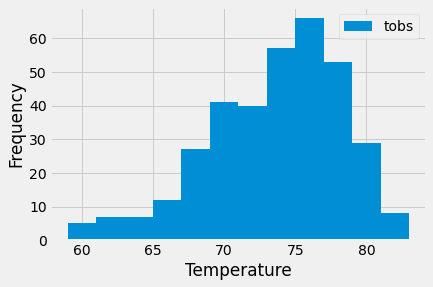

In [33]:
# plot the results as a histogram
temp_obs_df.plot(kind="hist", bins=12)
# plt.title("Histogram of Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig("Images/sabrina_temphist.png")
plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )


# function usage example
print(calc_temps("2012-02-28", "2012-03-05"))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.

In [22]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [24]:
# Create a query that will calculate the daily normals
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)


def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """

    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    return (
        session.query(*sel)
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )


daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [27]:
# Plot the daily normals as an area plot with `stacked=False`